# Exercise 2.7

What is the theoretic upper bound of the mapping error of a trajectory of n points into a squared tessellation of size s meters?
And what is this upper bound for a hexagonal or triangular tessellation?

* Use a real trajectory dataset and map the trajectory into a tessellation. Compute the error. Is it actually lower than the theoretic upper bound?
* Submit a (well-documented) notebook

## Installing the packages

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi
!pip install pypdf2 #to read a pdf in the folder of the dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 424 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 4.9 MB/s 
     |███████████████

## Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to create the convex hull
from shapely.geometry import MultiPoint

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#to download and extract the trajectory files
import urllib.request
import zipfile
import os
import PyPDF2 as pdf

## Downloading, Extracting and Exploring the Data
I discovered later that the entire process could be simplified by using scikit-mobility which already included the dataset:

```
url = skmob.utils.constants.GEOLIFE_SAMPLE
df = pd.read_csv(url, sep=',', compression='gzip')
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lon', user_id='user', datetime='datetime'
```

<b>But considering the effort I put in cleaning the data I decided to leave the preprocessing I made manually</b>

In [ ]:
file_name = 'Geolife Trajectories 1.3'
zip_name = file_name+'.zip'

#downloading the first trajectory dataset I could find
urllib.request.urlretrieve('https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip', zip_name)

#extracting the zipped files
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()
#removing the zip
os.remove(zip_name)
#listing files and directories in cwd
os.listdir()

['.config', 'Geolife Trajectories 1.3', 'sample_data']

In [ ]:
#listing files in the sub folder extracted
dir_path = f'{os.getcwd()}/{file_name}'
os.listdir(dir_path)

['User Guide-1.3.pdf', 'Data']

In [ ]:
PDF_read = pdf.PdfFileReader(temp)
#I read only the first page where there is a general description 
first_page = PDF_read.getPage(0)
print(first_page.extractText())

User Guide  
Version 1.3  (2012/08 /01) 
1. Data Description  
This GPS trajectory dataset  was collected in (Microsoft Research Asia) Geolife  project by 182 users in a period of over five years 
(from April 2007 to August 2012 ). A GPS trajectory of this dataset is represented by a sequence of time-stamped points, each of 
which contains the information of latitude, longitude and altitude.  This dataset contains 17,621 trajectories with a total distance  of 
1,292,951kilometers  and a total duration of  50,176 hours . These trajectories were recorded by different GPS loggers and GPS -
phones, and have a variety of sampling rates. 91.5 percent of the trajectories are logged in a dense representation, e.g. every 1~5 
seconds or every 5~10 meters per point.  
This dataset recoded a broad range of users’ outdoor movements, including not only life routines like go hom e and go to work 
but also some  entertainments and spo rts activities, such as  shopping, sightseeing, dining, hiking, an

In [ ]:
path_to_000 = f'{dir_path}/Data/000/Trajectory'
trajectory_files_000 = os.listdir(path_to_000) #it seems there are date and time in the name
trajectory_files_000[:5] #showing first 5 files to understand how they are stored

['20090608060034.plt',
 '20081210023503.plt',
 '20090518064638.plt',
 '20090412004905.plt',
 '20090629173335.plt']

In [ ]:
#example_file = f'{path_to_000}/{trajectory_files_000[0]}' #path to the first file I got
example_file = f'{path_to_000}/20090410021935.plt' #in some trials other files came first in the order, thus I explicitated the one I firstly used
print(example_file)
print('It cannot be read like this: \nskmob.TrajDataFrame.from_file(example_file)')
#skmob.TrajDataFrame.from_file(example_file)

/content/Geolife Trajectories 1.3/Data/000/Trajectory/20090410021935.plt
It cannot be read like this: 
skmob.TrajDataFrame.from_file(example_file)


In [ ]:
#opening the file which is similar to a csv
with open(example_file, 'r') as f:
    csv = f.readlines()

In [ ]:
#checking where data starts (after checking is at row with index 6)
csv[:7]

#the crs is the correct one being wgs 84 = epsg 4326

['Geolife trajectory\n',
 'WGS 84\n',
 'Altitude is in Feet\n',
 'Reserved 3\n',
 '0,2,255,My Track,0,0,2,8421376\n',
 '0\n',
 '40.011736,116.322001,0,-381,39913.0969328704,2009-04-10,02:19:35\n']

## Cleaning the Data

In [ ]:
#preprocessing the csv before building DF
csv_list = [(row.replace('\n','').split(',')) for row in csv[6:]]
csv_array = np.array(csv_list)
#removing the second, third and fifth (col[2] is always 0, col[3] stores the altitude, col[4] I don't get what it stores)
csv_clean = np.delete(csv_array, [2, 3, 4], axis=1)
#building a pandas dataframe to concatenate columns of date and time easily
pandas_df = pd.DataFrame(csv_array)
date_time_col = pd.to_datetime(pandas_df[5]+' '+pandas_df[6]).values
#finilizing the csv to import it
csv_clean = np.delete(csv_clean, [2, 3], axis=1) #removing old date and time columns
data = pd.DataFrame(csv_clean) #numpy couldn't concatenate the datetime format for some reasons
data['datetime'] = date_time_col #thus lat, lng, datetime

In [ ]:
tdf = skmob.TrajDataFrame(data, latitude=0, longitude=1, datetime=2)
tdf.head()

lat         lng            datetime
0  40.011736  116.322001 2009-04-10 02:19:35
1  40.011499  116.321947 2009-04-10 02:19:40
2  40.011578  116.321998 2009-04-10 02:19:45
3  40.011466  116.321946 2009-04-10 02:19:50
4  40.011443  116.321915 2009-04-10 02:19:55

## Creating the Tessellation

In [ ]:
side_length = 3000

In [ ]:
#creating a squared tassellation for Florence, each square 500 meters each
tess_squared = tiler.get('squared', base_shape='Beijing, China', meters=side_length)
print(f"tiles = {len(tess_squared)}")
tess_squared.head()

tiles = 3357


tile_ID                                           geometry
0       0  POLYGON ((115.41721 39.73237, 115.41721 39.753...
1       1  POLYGON ((115.41721 39.75310, 115.41721 39.773...
2       2  POLYGON ((115.41721 39.77381, 115.41721 39.794...
3       3  POLYGON ((115.41721 39.93931, 115.41721 39.959...
4       4  POLYGON ((115.41721 39.95997, 115.41721 39.980...

In [ ]:
#creating a map with the tessellation of Beijing (where the trajectory is located)
squared_map = plot_gdf(tess_squared, zoom=10) #I won't use it anymo

In [ ]:
#showing the trajectory on the tessellation
tdf.plot_trajectory(map_f = squared_map, hex_color = '#ff0000', weight=3, opacity=0.9)

## Creating the Convex Hull of the Trajectory (to reduce the size of the tessellation)

In [ ]:
#IMPORTANT HERE FIRST LNG THEN LAT (ON FOLIUM NO PROBLEM, PROBABLY CORRECT PLACING ERRORS BUT GEOPANDAS SPATIAL JOINS IMPOSSIBLE OTHERWISE)

#creating the points of the trajectory
traj_points = gpd.points_from_xy(tdf.lng, tdf.lat)
#creating the convex hull from that geometry
convex_hull_traj = MultiPoint(traj_points).convex_hull

Here under I wanted just to try to add on the map the polygon of the convex hull of the trajectory, it works but it was just a test to check if the polygon would be plotted in the right location, once checked I just commented it out

In [ ]:
#style = {"fillColor": 'Blue',"fillOpacity": 0.8,"weight": 0.8,"color": 'Blue'}
#folium.Polygon(locations = list(convex_hull_traj.exterior.coords), style_function=style).add_to(squared_map)
#squared_map

## Reducing the tessellation (it was a test for embellishing purposes)
I did it because I wanted to try to embellish the plot by only selecting a reduced area of the tessellation to plot but not limiting it to the tiles touching the trajectory (as I will do later to solve the exercise)

In [ ]:
#creating a geodataframe of the convexhull polygon
gpd_convex = gpd.GeoDataFrame(np.array([convex_hull_traj]), columns=['geometry'], crs ='EPSG:4326')
#doing a spatial join between the convex hull and the tessellation and dropping useless index of convex hull
new_tessellation = gpd.sjoin(tess_squared, gpd_convex).drop('index_right', axis=1)
#creating the map with new limited squared tessellation
tessellated_map = plot_gdf(new_tessellation, zoom=11)

In [ ]:
print(f'Number of tiles: {len(new_tessellation)}')

Number of tiles: 52


In [ ]:
#I deleted the output because another map increases the size of the notebook too much
tdf.plot_trajectory(map_f = tessellated_map, hex_color = '#ff0000', weight=3, opacity=0.9)

# Spatial join between the tessellation and the trajectory
It's different from the join between the convex hull and the Beijing squared tessellation, this time only tiles overlapping with the trajectory should appear in the joined df

In [ ]:
#adding the centroid of the tessellation to the geodf
#I changed the crs because of a warning, probably centroid is better to be calculated in projection not with earth distances
#I changed back the crs once finished computing the centroid
new_tessellation['tile_centroid'] = new_tessellation.to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
new_tessellation['tile_geometry'] = new_tessellation['geometry'] #storing the tile geometry that will be deleted after merging
print(len(new_tessellation))
new_tessellation.head()

52


tile_ID                                           geometry  \
1127    1127  POLYGON ((116.19874 39.81522, 116.19874 39.835...   
1128    1128  POLYGON ((116.19874 39.83592, 116.19874 39.856...   
1129    1129  POLYGON ((116.19874 39.85661, 116.19874 39.877...   
1130    1130  POLYGON ((116.19874 39.87730, 116.19874 39.897...   
1131    1131  POLYGON ((116.19874 39.89798, 116.19874 39.918...   

                   tile_centroid  \
1127  POINT (116.21222 39.82557)   
1128  POINT (116.21222 39.84627)   
1129  POINT (116.21222 39.86695)   
1130  POINT (116.21222 39.88764)   
1131  POINT (116.21222 39.90831)   

                                          tile_geometry  
1127  POLYGON ((116.19874 39.81522, 116.19874 39.835...  
1128  POLYGON ((116.19874 39.83592, 116.19874 39.856...  
1129  POLYGON ((116.19874 39.85661, 116.19874 39.877...  
1130  POLYGON ((116.19874 39.87730, 116.19874 39.897...  
1131  POLYGON ((116.19874 39.89798, 116.19874 39.918...

In [ ]:
#creating a geodataframe with a geometry from lat and lng of the trajectory
geo_tdf = gpd.GeoDataFrame(tdf, geometry=traj_points, crs = 'EPSG:4326')

#visualizing the new geo dataframe
print(len(geo_tdf))
geo_tdf.head()

1886


lat         lng            datetime                    geometry
0  40.011736  116.322001 2009-04-10 02:19:35  POINT (116.32200 40.01174)
1  40.011499  116.321947 2009-04-10 02:19:40  POINT (116.32195 40.01150)
2  40.011578  116.321998 2009-04-10 02:19:45  POINT (116.32200 40.01158)
3  40.011466  116.321946 2009-04-10 02:19:50  POINT (116.32195 40.01147)
4  40.011443  116.321915 2009-04-10 02:19:55  POINT (116.32192 40.01144)

In [ ]:
#joining the tessellation with the geo dataframe (dropping again index_right because the tile_ID is identical and semantically meaningful)
joined_gdf = gpd.sjoin(geo_tdf, new_tessellation).drop('index_right', axis=1)
joined_gdf['trajectory_geometry'] = joined_gdf['geometry'] #storing in a new column the trajectory points (it may be useful)
joined_gdf.head()

lat         lng            datetime                    geometry  \
0  40.011736  116.322001 2009-04-10 02:19:35  POINT (116.32200 40.01174)   
1  40.011499  116.321947 2009-04-10 02:19:40  POINT (116.32195 40.01150)   
2  40.011578  116.321998 2009-04-10 02:19:45  POINT (116.32200 40.01158)   
3  40.011466  116.321946 2009-04-10 02:19:50  POINT (116.32195 40.01147)   
4  40.011443  116.321915 2009-04-10 02:19:55  POINT (116.32192 40.01144)   

  tile_ID               tile_centroid  \
0    1393  POINT (116.32002 40.01159)   
1    1393  POINT (116.32002 40.01159)   
2    1393  POINT (116.32002 40.01159)   
3    1393  POINT (116.32002 40.01159)   
4    1393  POINT (116.32002 40.01159)   

                                       tile_geometry  \
0  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
1  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
2  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
3  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
4  POLYGON ((116.30654 40.00127, 116.30654 40.021...   

          trajectory_geometry  
0  POINT (116.32200 40.01174)  
1  POINT (116.32195 40.01150)  
2  POINT (116.32200 40.01158)  
3  POINT (116.32195 40.01147)  
4  POINT (116.32192 40.01144)

In [ ]:
#creating gdfs to plot the other geometry remaining from the join with the trajectory
to_centroid = joined_gdf.copy(deep=True)
to_centroid['geometry'] = to_centroid['tile_centroid']
to_centroid.drop('tile_centroid', axis=1)

to_tile = joined_gdf.copy(deep=True)
to_tile['geometry'] = to_tile['tile_geometry']
to_tile.drop('tile_geometry', axis=1)
print()

## Visualizing everything

In [ ]:
tiles = plot_gdf(to_tile, zoom = 11)
tdf.plot_trajectory(map_f = tiles, hex_color = '#ff0000', weight=3, opacity=0.9, max_points=None)
plot_gdf(to_centroid, map_f = tiles)

## Computing Maximum Possible Mapping Error

I will compute the distances between each point of the trajectory and the centroid of the tile it has been assigned to, to get to the total error I considered the following mathematic assumptions that should be valid for each regular figure (thus squares, equilater triangles, hexagons).</br></br>



Given a regular polygon with:
* $ s =$ single side length in meters
* $ n_s =$ number of sides
* $ N_T =$ total number of tiles
* $ N_P =$ total number of points of the trajectory

$\phi = {\cot} (\pi / n_s)$ is the fixed number of the regular polygon shape

$\phi = 1$ in the case of a square, about $0.58$ in the case of equilater triangle and about $1.73$ in the case of a hexagon

$\alpha = (s/2) \cdot \phi $ is the apothema

$A_t = (s \cdot n_s \cdot \alpha)/2 $ is the area of a regular tile

$\Omega = \sum_{t}^{T} A_t = A_t \cdot N_T$ is the total area of the tessellation encompassing the trajectory</br></br>

Given an infinite number of points the error should point towards infinity as there are infinite number of possible trajectories inside a tile: $\lim_{N_p\to+\infty} x = +\infty$

</br>
</br>

<b>Now to compute $x$:</b>

$Coord_p = (Lat_p, Lon_p)$ are the coordinates of a point $p$

$Coord_{C_t} = \frac{1}{N_s}\sum_{k}^{N_s} Coord_k$ are the coordinates of the centroid of a tile $t$, $\forall t \in T$

With $Coord_k$ being a vertex $v \in V$ (set of vertices of the regular polygon with $N_s$ sides)

The Haversine formula with $r = 6371{\text {km}}$, the average radius of earth, is:

$hav(Coord_P, Coord_Q) = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{Lat_Q - Lat_P}{2}\right) + \cos Lat_P \cdot \cos Lat_Q \cdot \sin^2\left(\frac{Lon_Q - Lon_P}{2}\right)}\right)$

</br>
</br>

The error of mapping some points to a tile $t$, $\forall t \in T$, may be equal to the distance of the point from the centroid. Considering I would like to have a generic error it may be usefull to square the errors in meters to later divide them by the area of the tile (in meter squared) so that the error is without unit measures:

$E(p, t) = \sum_{p}^{N_p} hav(Coord_p, Coord_{C_t})^2, \forall p \cap t$

The error $E(p, t)$ points towards infinity with an infinite number of points as I was guessing with the previous limit.

As said this measure is in meter squared, but for every tile that intersect with the trajectory $x$ may be divided by the Area of the tile, finally summing up errors without a unit measure: $\sum_{t}^{T} \frac{1}{A_t} E(p, t)$

</br>

In consequence of the above considerations the total error may be:

$T(E) = Total Error = \sum_{t}^{T} \frac{1}{A_t} \sum_{p}^{N_p} hav(Coord_p, Coord_{C_t})^2, \forall p \cap t$

</br>
For the purposes of this exercise I think I can omitt the $\frac{1}{A_t}$ and express the error in meters (not elevating to the power of two)
</br>

This should be true for every regular figure: 
</br><b>For a single point the maximum possible error should be being on a vertex of a tile</b>, where the distance from the centroid of the tile is maximized, the second maximum distance is near the vertex and then on the border of the tile.

In [ ]:
border_coords = list(joined_gdf['tile_geometry'][0].exterior.coords)
border_coords #the last is identical to the first, probably the origin or something like that

[(116.3065407312783, 40.001274354898044),
 (116.3065407312783, 40.02191533157423),
 (116.33349018980189, 40.02191533157423),
 (116.33349018980189, 40.001274354898044),
 (116.3065407312783, 40.001274354898044)]

In [ ]:
centroid_coords = list(joined_gdf['tile_geometry'][0].centroid.coords) #storing the coordinates of the centroid
centroid_coords

[(116.32001546054012, 40.011594843236146)]

In [ ]:
#I already written this in a previous exercise (1.1 if I'm not wrong)

from math import cos, sin, asin, sqrt, pi, tan

def to_radians(*args): #I needed radians to work with trigonometry
    for raw in args:
        yield raw*(pi/180) #I made it a generator out of convenience

def haversine_formula(latP, lonP, latQ, lonQ):
    #converting the latitude and longitudes to radians
    latP, lonP, latQ, lonQ = tuple(to_radians(latP, lonP, latQ, lonQ))
    #print(latP, lonP, latQ, lonQ)

    earth_radius = 6371 #km, from wikipedia

    Dlat = latQ - latP
    Dlon = lonQ - lonP

    #I copied and translated the formula to python
    to_sqrt = sin(Dlat/2)**2 + cos(latP)*cos(latQ)*sin(Dlon/2)**2
    d = 2*earth_radius*asin(sqrt(to_sqrt))

    return  d

In [ ]:
#COMPUTING THE ERROR ACCORDING TO MY FORMULA
error = list()
sides = len(border_coords)-1 #-1 there is a coordinate of an extra point
tile_area = ((side_length**2)*sides*(1/tan(pi/sides)/2))/2 #it should be the same for every tile for it to be a regular tessellation

for n in range(len(joined_gdf)):
    latP = joined_gdf['trajectory_geometry'][n].y
    lonP = joined_gdf['trajectory_geometry'][n].x
    latQ = joined_gdf['tile_centroid'][n].y
    lonQ = joined_gdf['tile_centroid'][n].x
    error.append((haversine_formula(latP, lonP, latQ, lonQ)**2)/tile_area)

In [ ]:
#computing maximum possible error
lonP, latP = border_coords[0]
lonQ, latQ = centroid_coords[0] #[0] because this is also a list
max_error_theory = (haversine_formula(latP, lonP, latQ, lonQ)**2)/tile_area
max_error_theory

2.9267846060380667e-07

In [ ]:
#adding the error to the geo dataframe
joined_gdf['mapping_error'] = error
joined_gdf.head()

lat         lng            datetime                    geometry  \
0  40.011736  116.322001 2009-04-10 02:19:35  POINT (116.32200 40.01174)   
1  40.011499  116.321947 2009-04-10 02:19:40  POINT (116.32195 40.01150)   
2  40.011578  116.321998 2009-04-10 02:19:45  POINT (116.32200 40.01158)   
3  40.011466  116.321946 2009-04-10 02:19:50  POINT (116.32195 40.01147)   
4  40.011443  116.321915 2009-04-10 02:19:55  POINT (116.32192 40.01144)   

  tile_ID               tile_centroid  \
0    1393  POINT (116.32002 40.01159)   
1    1393  POINT (116.32002 40.01159)   
2    1393  POINT (116.32002 40.01159)   
3    1393  POINT (116.32002 40.01159)   
4    1393  POINT (116.32002 40.01159)   

                                       tile_geometry  \
0  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
1  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
2  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
3  POLYGON ((116.30654 40.00127, 116.30654 40.021...   
4  POLYGON ((116.30654 40.00127, 116.30654 40.021...   

          trajectory_geometry  mapping_error  
0  POINT (116.32200 40.01174)   3.204871e-09  
1  POINT (116.32195 40.01150)   3.019155e-09  
2  POINT (116.32200 40.01158)   3.167964e-09  
3  POINT (116.32195 40.01147)   3.026160e-09  
4  POINT (116.32192 40.01144)   2.939293e-09

In [ ]:
max_error_real = joined_gdf['mapping_error'].max() #which is lower than the maximum possible error
max_error_real

2.7992698965571894e-07

In [ ]:
assert max_error_real <= max_error_theory, "It's not lower than the maximum possible error"
assert max_error_real <= max_error_theory, "It's not lower than the maximum possible error"

In [ ]:
total_max_error_theory = max_error_theory*len(joined_gdf)
total_max_error_reality = joined_gdf['mapping_error'].sum()

In [ ]:
assert total_max_error_reality <= total_max_error_theory, "It's not lower than the maximum possible error"

I tried to visualize the points with the highest error to confirm... But it gave me a strange result. </br>
I tried to fix it spending a lot of time on it but it was fruitless (I tried several crs, I also started to think my haversine formula may be wrong, the error I'm making is still not clear to me)

In [ ]:
#setting the 75 quantile to plot only errors over it
seventyfive_q = joined_gdf['mapping_error'].quantile(0.75)

tiles = plot_gdf(to_tile, zoom = 11)
tdf.plot_trajectory(map_f = tiles, hex_color = '#ff0000', weight=3, opacity=0.9, max_points=None)
plot_gdf(to_centroid, map_f = tiles)
plot_gdf(joined_gdf[joined_gdf['mapping_error'] > seventyfive_q], map_f=tiles)


/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  start_end_markers=start_end_markers, control_scale=control_scale)


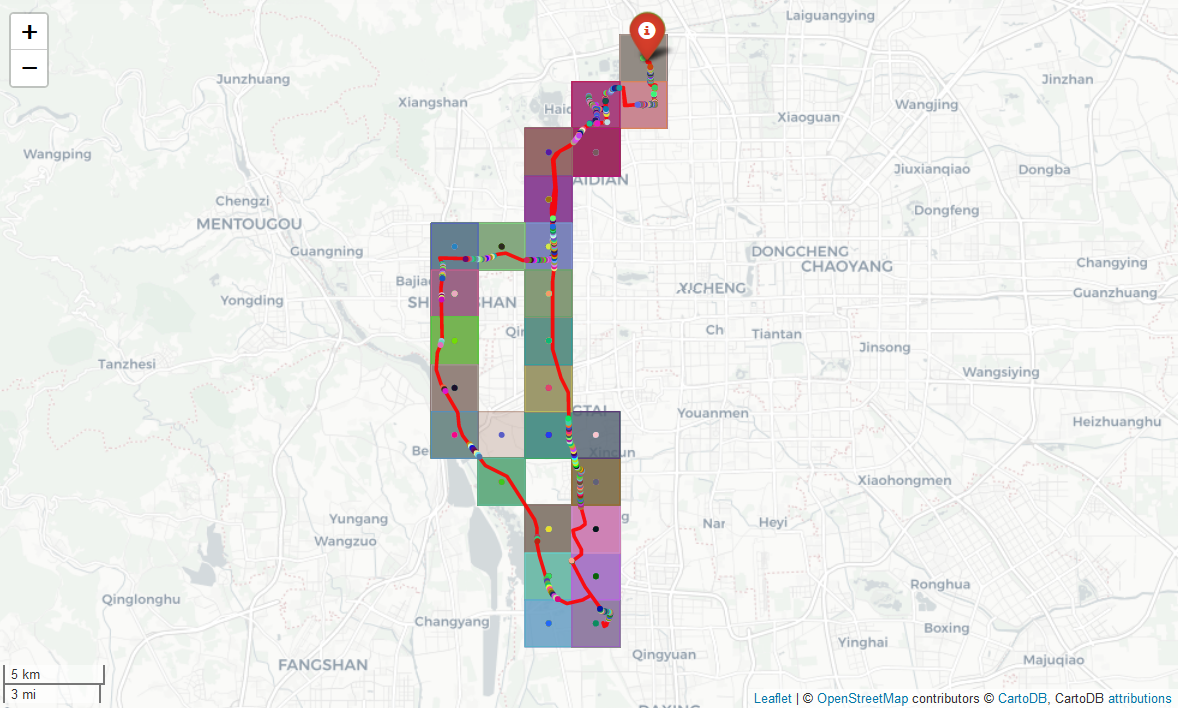